This script is is used for object detection for circular bounding boxes. Script present four models:

- first gen model before data augmentation
- first gen model after data augmentation
- second gen model after data augmentation
- third gen model after data augmentation

In [1]:
# Loading all lib
import pandas as pd
import os
import glob
import cv2
import numpy as np
import json
from keras import layers
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Masking, MaxPooling2D, Lambda,UpSampling2D, Reshape, Input
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from sklearn.preprocessing import MaxAbsScaler
from random import shuffle
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform

Functions needed to load and process data. They are described in script about final model for cicular bboxes.

In [2]:
##Usefull functions

def create_df(path_annotations_circle):
    all_files = glob.glob(path_annotations_circle + "\\*.csv")
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    df_circle = df[['name', 'c-x', 'c-y', 'radius']]

    return df_circle

def get_max_number(df_circle):
    value = df_circle.groupby('name').agg('count').sort_values('radius', ascending=False).max()[['radius']].tolist()
    return value[0]

def get_bbox_cords(df_circle):
    gb = df_circle.groupby('name')    
    gb = [gb.get_group(x) for x in gb.groups]


    list =[]
    for set_of_df in gb:
        lista = []
        for i in range(18*3):
            if str(set_of_df['radius'].values.tolist()[0]) == 'nan':
                lista.append(0)
            else:
                lista = set_of_df[['c-x','c-y','radius']].stack().tolist()
                number = 54 - len(lista)
                a = [0]*number
                lista = lista + a
                break
        list.append(lista)

    return list

def get_bbox_cords_to_dict(df_circle):
    gb = df_circle.groupby('name')    
    gb = [gb.get_group(x) for x in gb.groups]

    dict = {}
    list =[]
    for set_of_df in gb:
        name = (set_of_df['name'].values.tolist()[0].replace('.csv', ''))
        lista = []
        for i in range(18*3):
            if str(set_of_df['radius'].values.tolist()[0]) == 'nan':
                lista.append(0)
            else:
                lista = set_of_df[['c-x','c-y','radius']].stack().tolist()
                number = 54 - len(lista)
                a = [0]*number
                lista = lista + a
                break
        list.append(lista)
        dict.update({name:lista})

    return dict

def get_image_data(imagespath):
  path = glob.glob(imagespath + '\\*.png')
  images=[cv2.imread(file) for file in path]
  return images


def apply_threshold_and_split_pred(trainprediction, thresh):
    prediction = []
    three_coord_list = []
    iter = 0
    prediction_threshold = trainprediction

    for i in range(len(prediction_threshold[0])):
        if prediction_threshold[0][i] < thresh:
            prediction_threshold[0][i] = 0

    for elem in prediction_threshold[0]:
        if iter < 3:
            three_coord_list.append(elem)
            iter +=1
        else:
            iter = 1
            prediction.append(three_coord_list)
            three_coord_list = []
            three_coord_list.append(elem)
    prediction.append(three_coord_list)

    return prediction

def split_origin(origin_img):
    origin = []
    three_coord_list = []
    iter = 0

    for elem in origin_img:
        if iter < 3:
            three_coord_list.append(elem)
            iter +=1
        else:
            iter = 1
            origin.append(three_coord_list)
            three_coord_list = []
            three_coord_list.append(elem)
    origin.append(three_coord_list)

    return origin

def draw_circle(ax, Color, coords):
    for elem in coords:
        x = float(elem[0])
        y = float(elem[1])
        radius = float(elem[2])
        circ = Circle((x,y),radius, fill=False, color = Color)
        ax.add_patch(circ)
    return ax


def plot_results(img, prediction, original_coords):

    fig,ax = plt.subplots(1)
    ax.imshow(img, interpolation='nearest')

    ax = draw_circle(ax, 'Red', prediction)
    ax = draw_circle(ax, 'Blue', original_coords)

    plt.show()


def calculate_iou(prediction, original_coords):
    iter = 0 
    iou_list = []
    for pred_elem, original_elem in zip(prediction,original_coords):
        iter +=1
        c1_x = pred_elem[0]
        c1_y = pred_elem[1] 
        r1 = pred_elem[2] 
        c2_x = original_elem[0]
        c2_y = original_elem[1]
        r2 = original_elem[2]

        if c2_x == 0 and c2_y == 0 and r2 == 0:
            iou = 'NoOriginObject'
        else:

            distance = np.sqrt((c1_x - c2_x)**2 + (c1_y - c2_y)**2)
            

            if distance > r1 + r2:
                return 0.0

            elif (distance <= (r1 - r2) and r1 >= r2):
                intersection_area = np.pi * r2 * r2
        
            elif (distance <= (r2 - r1) and r2 >= r1):
                intersection_area = np.pi * r1 * r1
        
            else :
                alpha = np.arccos(((r1 * r1) + (distance * distance) - (r2 * r2)) / (2 * r1 * distance)) * 2
                beta = np.arccos(((r2 * r2) + (distance * distance) - (r1 * r1)) / (2 * r2 * distance)) * 2
                
                a1 = (0.5 * beta * r2 * r2 ) - (0.5 * r2 * r2 * np.sin(beta))
                a2 = (0.5 * alpha * r1 * r1) - (0.5 * r1 * r1 * np.sin(alpha))
                intersection_area = a1 + a2
                
            area1 = np.pi * r1**2
            area2 = np.pi * r2**2

            union_area = area1 + area2 - intersection_area
                
            iou = intersection_area / union_area

        iou_list.append(iou)
        print(f'{iter}: Original: {original_elem} | Predicted: {pred_elem} | IOU: {iou}')

    return iou_list


def calculate_iou_with_probability(prediction, original_coords, probability):
    iter = 0 
    i = 0
    iou_list = []
    for pred_elem, original_elem in zip(prediction,original_coords):
        iter +=1
        c1_x = pred_elem[0]
        c1_y = pred_elem[1] 
        r1 = pred_elem[2] 
        c2_x = original_elem[0]
        c2_y = original_elem[1]
        r2 = original_elem[2]

        if c2_x == 0 and c2_y == 0 and r2 == 0:
            iou = 'NoOriginObject'
        else:
  
            distance = np.sqrt((c1_x - c2_x)**2 + (c1_y - c2_y)**2)
            
   
            if distance > r1 + r2:
                return 0.0
    
            elif (distance <= (r1 - r2) and r1 >= r2):
                intersection_area = np.pi * r2 * r2
        
            elif (distance <= (r2 - r1) and r2 >= r1):
                intersection_area = np.pi * r1 * r1
        
            else :
                alpha = np.arccos(((r1 * r1) + (distance * distance) - (r2 * r2)) / (2 * r1 * distance)) * 2
                beta = np.arccos(((r2 * r2) + (distance * distance) - (r1 * r1)) / (2 * r2 * distance)) * 2
                
                a1 = (0.5 * beta * r2 * r2 ) - (0.5 * r2 * r2 * np.sin(beta))
                a2 = (0.5 * alpha * r1 * r1) - (0.5 * r1 * r1 * np.sin(alpha))
                intersection_area = a1 + a2
                
            area1 = np.pi * r1**2
            area2 = np.pi * r2**2
   
            union_area = area1 + area2 - intersection_area
                
            iou = intersection_area / union_area

        iou_list.append(iou)
        print(f'{iter}: Original: {original_elem} | Predicted: {pred_elem} | Probability: {round(float(probability[0][iter-1]), 3)} | IOU: {iou}')
        i = i + 1

    return iou_list

def calculate_prob(list_of_coords):
    probability = []
    list_of_prob = []
    for set_ in list_of_coords:
        lst = set_[::3]
        for value in lst:
            if value != 0:
                probability.append(1)
            else:
                probability.append(0)
        list_of_prob.append(probability)
        probability = []
    
    return list_of_prob


def dataset_shuffle(images,list_of_prob,list_of_coords,bool):
    if bool == True:
        whole_set = []
        for img, prob, coord in zip(images,list_of_prob ,list_of_coords):
            one_set = []
            one_set.append(img)
            one_set.append(prob)
            one_set.append(coord)
            whole_set.append(one_set)

        shuffle(whole_set)
        img_sh = []
        prob_sh =[]
        coord_sh = []

        for set_ in whole_set:
            img_sh.append(set_[0])
            prob_sh.append(set_[1])
            coord_sh.append(set_[2])

        return img_sh, prob_sh, coord_sh
    else:
        return images, list_of_prob, list_of_coords

def reverse_transform_data_only_coords(data, grid_size):
    image_height, image_width = 202, 308
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]
    
    coords_final = []

    for batch_data in data.reshape((-1, grid_size[0] * grid_size[1], 3)):
        batch_coords = []

        for y in range(grid_size[0]):
            for x in range(grid_size[1]):
                local_x, local_y, r = batch_data[y * grid_size[1] + x] 
                global_x = x * cell_width + local_x
                global_y = y * cell_height + local_y
                
                batch_coords.extend([global_x, global_y, r])

        coords_final.append(batch_coords)

    return coords_final

def reverse_transform_deep_nested_coords(batch_data, grid_size):
    
    image_height, image_width = 202, 308
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]
    
    output_list = []

    for y in range(grid_size[0]):
        for x in range(grid_size[1]):
            local_coords1 = batch_data[0][y][x][0]
            local_coords2 = batch_data[0][y][x][1]
            
            global_x1 = x * cell_width + local_coords1[0]
            global_y1 = y * cell_height + local_coords1[1]
            
            global_x2 = x * cell_width + local_coords2[0]
            global_y2 = y * cell_height + local_coords2[1]
            
            output_list.append(global_x1)
            output_list.append(global_y1)
            output_list.append(local_coords1[2])
            output_list.append(global_x2)
            output_list.append(global_y2)
            output_list.append(local_coords2[2])

    return np.array(output_list)

def Iou(prediction, original_coords):
    iter = 0 
    iou_list = []
    for pred_elem, original_elem in zip(prediction,original_coords):
        iter +=1
        c1_x = pred_elem[0]
        c1_y = pred_elem[1] 
        r1 = pred_elem[2] 
        c2_x = original_elem[0]
        c2_y = original_elem[1]
        r2 = original_elem[2]

        if c2_x == 0 and c2_y == 0 and r2 == 0:
            iou = -1
        else:
            distance = np.sqrt((c1_x - c2_x)**2 + (c1_y - c2_y)**2)
            
            if distance > r1 + r2:
                return [0.0]
            elif (distance <= (r1 - r2) and r1 >= r2):
                intersection_area = np.pi * r2 * r2
        
            elif (distance <= (r2 - r1) and r2 >= r1):
                intersection_area = np.pi * r1 * r1
        
            else :
                alpha = np.arccos(((r1 * r1) + (distance * distance) - (r2 * r2)) / (2 * r1 * distance)) * 2
                beta = np.arccos(((r2 * r2) + (distance * distance) - (r1 * r1)) / (2 * r2 * distance)) * 2
                
                a1 = (0.5 * beta * r2 * r2 ) - (0.5 * r2 * r2 * np.sin(beta))
                a2 = (0.5 * alpha * r1 * r1) - (0.5 * r1 * r1 * np.sin(alpha))
                intersection_area = a1 + a2
                
            area1 = np.pi * r1**2
            area2 = np.pi * r2**2

            union_area = area1 + area2 - intersection_area
                
            iou = intersection_area / union_area

        iou_list.append(iou)

    return iou_list

def NMS(pred, iou_threshold, prob_threshold, prob):

    one_box = []
    predictions_with_prob =[]
    iter = 0
    iter_prob = 0
    for elem in pred:
        if iter == 2:
            iter = 0
            one_box.append(elem)
            one_box.append(prob[iter_prob])
            iter_prob += 1
            predictions_with_prob.append(one_box)
            one_box = []
        else:
            one_box.append(elem)
            iter += 1

    bbox_list_thresholded = []
    bbox_list_new = []

    box_sorted = sorted(predictions_with_prob, reverse=True, key = lambda x :x[3])

    for box in box_sorted:
        if box[3] > prob_threshold:
            bbox_list_thresholded.append(box)

    while len(bbox_list_thresholded) > 0:
        current_box = bbox_list_thresholded.pop(0)
        bbox_list_new.append(current_box)
        for box in bbox_list_thresholded:
            iou = Iou([current_box[:3]], [box[:3]])
            if iou[0] > iou_threshold:
                bbox_list_thresholded.remove(box)

    return bbox_list_new

def transform_data(coords, probs, grid_size, max_apples_per_cell=2):
    image_height, image_width = 202, 308
    
    transformed_coords_final = []
    transformed_probs_final = []

    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]

    for i in range(len(probs)):
        transformed_coords = np.zeros((grid_size[0], grid_size[1], max_apples_per_cell, 3))
        transformed_probs = np.zeros((grid_size[0], grid_size[1], max_apples_per_cell, 1))

        apple_counter = np.zeros((grid_size[0], grid_size[1]), dtype=int)

        for j in range(len(probs[0])):
            if probs[i][j] == 1: 
                x, y, r = coords[i][j*3:j*3+3]

                if x == image_width and y == image_height:
                    cell_x = 3
                    cell_y = 3
                elif x == image_width:
                    cell_x = 3
                    cell_y = int(np.floor(y // cell_height))
                elif y == image_height:
                    cell_x = int(np.floor(x // cell_width))
                    cell_y = 3
                else:
                    cell_x, cell_y = int(np.floor(x // cell_width)), int(np.floor(y // cell_height))
                
                local_x = (x % cell_width)
                local_y = (y % cell_height)
                
                if apple_counter[cell_y, cell_x] < max_apples_per_cell:
                    idx = apple_counter[cell_y, cell_x]
                    transformed_coords[cell_y, cell_x, idx] = [local_x, local_y, r]
                    transformed_probs[cell_y, cell_x, idx] = [1]  
                    
                    apple_counter[cell_y, cell_x] += 1

                   
        transformed_coords = transformed_coords.tolist()
        transformed_probs = transformed_probs.tolist()

        transformed_coords_final.append(transformed_coords)
        transformed_probs_final.append(transformed_probs)

    return transformed_coords_final, transformed_probs_final

def reverse_transform_data(data, grid_size):
    image_height, image_width = 202, 308
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]
    
    coords_final = []
    probs_final = []

    for batch_data in data:
        batch_coords = []
        batch_probs = []

        for y in range(grid_size[0]):
            for x in range(grid_size[1]):
                for apple_data in batch_data[y][x]:
                    local_x, local_y, r, prob = apple_data


                    global_x = x * cell_width + local_x
                    global_y = y * cell_height + local_y
                    
                    batch_coords.extend([global_x, global_y, r])
                    batch_probs.append(prob)  

        coords_final.append(batch_coords)
        probs_final.append(batch_probs)

    return coords_final, probs_final

Functions needed to caluclate mAP values for circular data. They are described in script about mAP calcularion for circular bboxes.

In [3]:
##Function for mAP Calc

def Iou_One_Val(pred_elem, original_elem):
    c1_x = pred_elem[0]
    c1_y = pred_elem[1] 
    r1 = pred_elem[2] 
    c2_x = original_elem[0]
    c2_y = original_elem[1]
    r2 = original_elem[2]

    if c2_x == 0 and c2_y == 0 and r2 == 0:
        return -1
    
    if c1_x == c2_x and c1_y == c2_y and r1 == r2:
        return 1

    distance = np.sqrt((c1_x - c2_x)**2 + (c1_y - c2_y)**2)
    
    if distance > r1 + r2:
        return 0.0

    elif (distance <= (r1 - r2) and r1 >= r2):
        intersection_area = np.pi * r2 * r2
 
    elif (distance <= (r2 - r1) and r2 >= r1):
        intersection_area = np.pi * r1 * r1
 
    else :
        alpha = np.arccos(((r1 * r1) + (distance * distance) - (r2 * r2)) / (2 * r1 * distance)) * 2
        beta = np.arccos(((r2 * r2) + (distance * distance) - (r1 * r1)) / (2 * r2 * distance)) * 2
         
        a1 = (0.5 * beta * r2 * r2 ) - (0.5 * r2 * r2 * np.sin(beta))
        a2 = (0.5 * alpha * r1 * r1) - (0.5 * r1 * r1 * np.sin(alpha))
        intersection_area = a1 + a2
        
    area1 = np.pi * r1**2
    area2 = np.pi * r2**2

    union_area = area1 + area2 - intersection_area
        
    return intersection_area / union_area


def calculate_precision_recall_at_iou(ground_truths, predictions, iou_thresholds):
    all_precisions = {iou_thresh: [] for iou_thresh in iou_thresholds}
    all_recalls = {iou_thresh: [] for iou_thresh in iou_thresholds}

    for iou_threshold in iou_thresholds:
        tp = 0
        fp = 0
        fn = len(ground_truths)
        empty_gt_count = sum(1 for gt in ground_truths if gt == [0, 0, 0])
        temp_ground_truths = [gt for gt in ground_truths if gt != [0, 0, 0]]

        for pred in predictions:
            best_iou = -1
            best_gt = None
            for gt in temp_ground_truths:
                iou = Iou_One_Val(pred, gt)
                if iou != -1 and iou >= best_iou:
                    best_iou = iou
                    best_gt = gt

            if best_iou >= iou_threshold:
                tp += 1
                temp_ground_truths.remove(best_gt)

        fn = fn - tp - empty_gt_count
        fp = len(predictions) - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        for iou_thresh in iou_thresholds:
            all_precisions[iou_thresh].append(precision)
            all_recalls[iou_thresh].append(recall)

    return all_precisions, all_recalls


def calculate_ap(precisions, recalls):

    sort_order = np.argsort(recalls)
    sorted_recalls = np.array(recalls)[sort_order]
    sorted_precisions = np.array(precisions)[sort_order]
    
    sorted_recalls = np.concatenate(([0.0], sorted_recalls, [1.0]))
    sorted_precisions = np.concatenate(([0.0], sorted_precisions, [0.0]))
    
    for i in range(len(sorted_precisions) - 2, -1, -1):
        sorted_precisions[i] = max(sorted_precisions[i], sorted_precisions[i + 1])

    ap = 0.0
    for i in range(1, len(sorted_recalls)):
        ap += ((sorted_recalls[i] - sorted_recalls[i - 1]) * sorted_precisions[i])

    return ap

def mean_average_precision(dataset, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    map_values = []

    for ground_truths, predictions in dataset:

        precisions, recalls = calculate_precision_recall_at_iou(ground_truths, predictions, iou_thresholds)
        ap_values = []
        for iou_threshold in iou_thresholds:
            ap = calculate_ap(precisions[iou_threshold], recalls[iou_threshold])
            ap_values.append(ap)

        map_values.append(np.mean(ap_values))

    mean_map = np.mean(map_values)
    return mean_map



PIERWSZY MODEL - PRZED AUGMENTACJĄ

In [4]:
# Loading file paths with raw data
path_annotations_circle = r'datasets_not_splited\annotations_circle'
path_images = r'datasets_not_splited\images'

#Functions invocation
df_circle = create_df(path_annotations_circle)
list_of_coords = get_bbox_cords(df_circle)
images = get_image_data(path_images)

#Inserting data into numpy arrays and splitting to train and test set
coords = np.array(list_of_coords)
img = np.array(images).astype(np.uint16)

test_set_coords = coords[896:1008]
test_set_img = img[896:1008]

train_set_coords = coords[:896]
train_set_img = img[:896]

valid_set_coords = coords[1008:]
valid_set_img = img[1008:]

print(len(test_set_coords))
print(len(test_set_img))
print(len(train_set_coords))
print(len(train_set_img))
print(len(valid_set_coords))
print(len(valid_set_img))

# Normalizing bboxes data
train_set_coords_transformer = MaxAbsScaler().fit(train_set_coords)
train_set_coords_scaled = train_set_coords_transformer.transform(train_set_coords)

test_set_coords_transformer = MaxAbsScaler().fit(test_set_coords)
test_set_coords_scaled = test_set_coords_transformer.transform(test_set_coords)

val_set_coords_transformer = MaxAbsScaler().fit(valid_set_coords)
val_set_coords_scaled = test_set_coords_transformer.transform(valid_set_coords)

112
112
896
896
112
112


In [4]:
# Define the input shape
input_shape = (202, 308, 3)

# Create the model
model = tf.keras.Sequential()

# Load VGG16 as the backbone (excluding the fully connected layers)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
model.add(vgg16)

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))
model.add(tf.keras.layers.ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))
model.add(tf.keras.layers.ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))
model.add(tf.keras.layers.ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))
model.add(tf.keras.layers.ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(Flatten())

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output Layer for multiple bounding box coordinates
model.add(Dense(54))  

# Set VGG16 layer not trainable
model.layers[0].trainable=False

# Compile the model with mean_squared_error loss for bounding box regression
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Train model
MODEL1_V0 = model.fit(train_set_img,
    train_set_coords_scaled,
    batch_size=64,
    epochs=50,
    verbose=2,
    shuffle = True,
    validation_data=(valid_set_img, val_set_coords_scaled)
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 9, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 6, 9, 256)         1179904   
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 5, 256)         0         
 D)                                                              
                                                                 
 zero_padding2d (ZeroPaddin  (None, 5, 7, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 7, 256)         590080    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 4, 256)         0

In [5]:
# Saving model
model.save('FINAL_MODELS/MODEL1_V1.h5')

C:\Users\mikolaj.martinek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


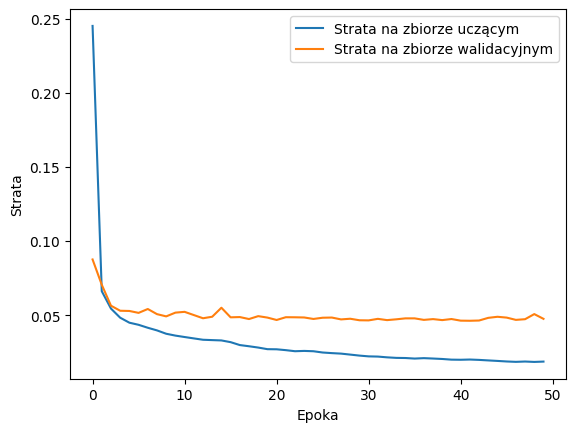

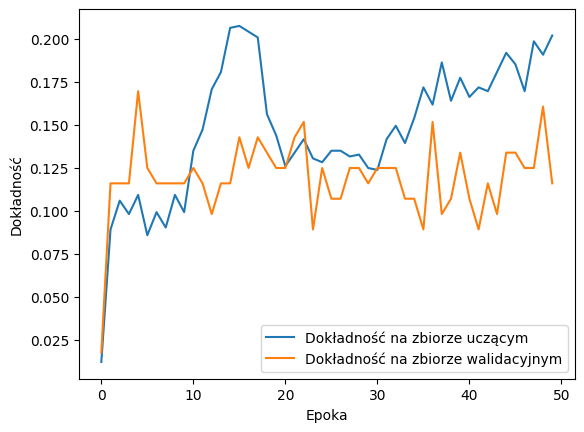

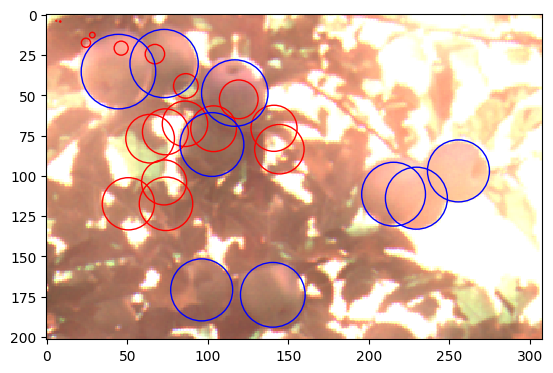

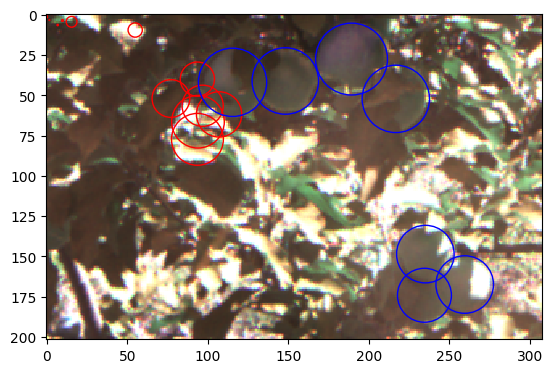

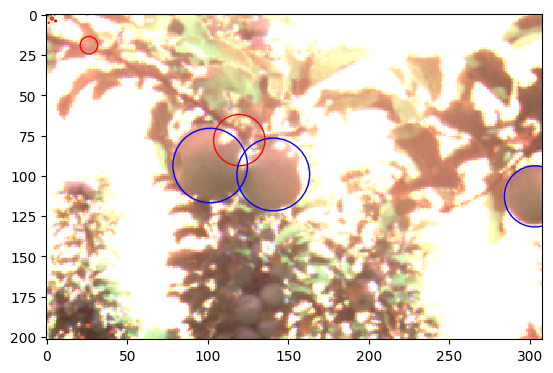

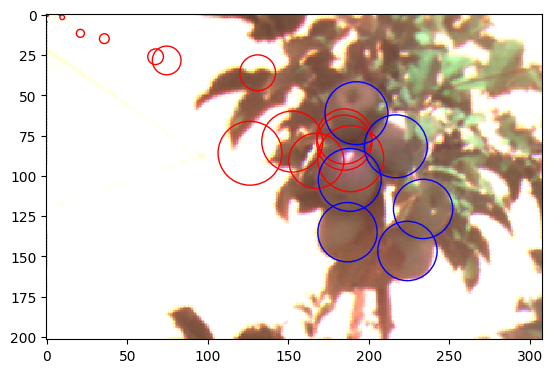

In [24]:
# Plot training and validation loss
plt.plot(MODEL1_V0.history['loss'], label='Training Loss')
plt.plot(MODEL1_V0.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(MODEL1_V0.history['accuracy'], label='Training Accuracy')
plt.plot(MODEL1_V0.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loop through the first 4 test images
for i in range(4):
    # Reshape the input test image
    input_image_reshaped = np.expand_dims(test_set_img[i], axis=0)
    
    # Make predictions using the model
    trainprediction = model.predict(input_image_reshaped)
    
    # Inverse transform the predictions using 'train_set_coords_transformer'
    trainprediction = train_set_coords_transformer.inverse_transform(trainprediction)
    
    # Apply a threshold and split the predictions
    prediction = apply_threshold_and_split_pred(trainprediction, 0)
    
    # Get the original coordinates from 'test_set_coords'
    original_coords = split_origin(test_set_coords[i])
    
    # Plot the results
    plot_results(test_set_img[i], prediction, original_coords)


In [8]:
# Print max and min values for metrics
print(max(MODEL1_V0.history['loss']))
print(max(MODEL1_V0.history['val_loss']))
print(max(MODEL1_V0.history['accuracy']))
print(max(MODEL1_V0.history['val_accuracy']))

print('--------------')

print(min(MODEL1_V0.history['loss']))
print(min(MODEL1_V0.history['val_loss']))
print(min(MODEL1_V0.history['accuracy']))
print(min(MODEL1_V0.history['val_accuracy']))

0.2450520247220993
0.08754567056894302
0.2075892835855484
0.1696428507566452
--------------
0.018450278788805008
0.04620625451207161
0.01227678544819355
0.01785714365541935


In [8]:
# Load model
model = load_model(
    r'<your model>',
    compile=False
)


# Initialize an empty dataset
dataset = []

# Define probability values
prob = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

subset_img  = train_set_img
subset_coords = train_set_coords

# Iterate over each item 
for i in range(len(subset_coords)):
    # Reshape the input validation image
    input_image_reshaped = np.expand_dims(subset_img[i], axis=0)
    
    # Make predictions using the model
    trainprediction = model.predict(input_image_reshaped, verbose=0)
    
    # Inverse transform the predictions using 'train_set_coords_transformer'
    trainprediction = train_set_coords_transformer.inverse_transform(trainprediction)
    
    # Apply Non-Maximum Suppression (NMS)
    pred_after_nms = NMS(trainprediction[0], 0.7, 0, prob)
    
    # Extract predictions without the last element (assuming it's a class label)
    only_pred_after_nms = []
    for list_ in pred_after_nms:
        only_pred_after_nms.append(list_[:-1])
    
    # Get the original coordinates 
    original_coords = split_origin(subset_coords[i])
    
    # Filter out coordinates with a last element less than or equal to zero
    original_coords_without_zeros = []
    for elem in original_coords:
        if elem[-1] > 0:
            original_coords_without_zeros.append(elem)
    
    # Append the tuple of original coordinates and post-NMS predictions to the dataset
    dataset.append((original_coords_without_zeros, only_pred_after_nms))

# Calculate the mean average precision (mAP) for the dataset
mean_map = mean_average_precision(dataset, iou_thresholds=np.arange(0.5, 1.0, 0.05))

print(f"Średnia mAP: {mean_map*100} %")

Średnia mAP: 0.08204207608969513 %


PIERWSZY MODEL - PO AUGMENTACJI 

In [9]:
# Loading file paths with raw data
path_img_test = r'datasets_splited\dataset\test_aug\images'
path_csv_test = r'datasets_splited\dataset\test_aug\annotations'

path_img_train = r'datasets_splited\dataset\train_aug\images'
path_csv_train = r'datasets_splited\dataset\train_aug\annotations'

path_img_val = r'datasets_splited\dataset\val_aug\images'
path_csv_val = r'datasets_splited\dataset\val_aug\annotations'

#Functions invocation
df_circle_test = create_df(path_csv_test)
list_of_coords_test = get_bbox_cords(df_circle_test)
images_test = get_image_data(path_img_test)
list_of_prob_test = calculate_prob(list_of_coords_test)

df_circle_train = create_df(path_csv_train)
list_of_coords_train = get_bbox_cords(df_circle_train)
images_train = get_image_data(path_img_train)
list_of_prob_train = calculate_prob(list_of_coords_train)

df_circle_val = create_df(path_csv_val)
list_of_coords_val = get_bbox_cords(df_circle_val)
images_val = get_image_data(path_img_val)
list_of_prob_val = calculate_prob(list_of_coords_val)



#Inserting data into numpy arrays and splitting to train and test set
test_set_coords = np.array(list_of_coords_test)
test_set_img = np.array(images_test)
test_set_prob = list_of_prob_test

train_set_coords = np.array(list_of_coords_train)
train_set_img = np.array(images_train)
train_set_prob = list_of_prob_train

valid_set_coords = np.array(list_of_coords_val)
valid_set_img = np.array(images_val)
valid_set_prob = list_of_prob_val

print(len(test_set_coords))
print(len(test_set_img))
print(len(train_set_coords))
print(len(train_set_img))
print(len(valid_set_coords))
print(len(valid_set_img))
print(len(train_set_prob))
print(len(test_set_prob))
print(len(valid_set_prob))

# Normalizing bboxes data
train_set_coords_transformer = MaxAbsScaler().fit(train_set_coords)
train_set_coords_scaled = train_set_coords_transformer.transform(train_set_coords)

test_set_coords_transformer = MaxAbsScaler().fit(test_set_coords)
test_set_coords_scaled = test_set_coords_transformer.transform(test_set_coords)

valid_set_coords_transformer = MaxAbsScaler().fit(valid_set_coords)
valid_set_coords_scaled = valid_set_coords_transformer.transform(valid_set_coords)

448
448
3584
3584
448
448
3584
448
448


In [18]:
# Define the input shape
input_shape = (202, 308, 3)

# Create the model
model = tf.keras.Sequential()

# Load VGG16 as the backbone (excluding the fully connected layers)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
model.add(vgg16)

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))
model.add(tf.keras.layers.ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))
model.add(tf.keras.layers.ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))
model.add(tf.keras.layers.ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))
model.add(tf.keras.layers.ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(Flatten())

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output Layer for multiple bounding box coordinates
model.add(Dense(54))  

# Set VGG16 layer not trainable
model.layers[0].trainable=False

# Compile the model with mean_squared_error loss for bounding box regression
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Train model
MODEL1_V1 = model.fit(train_set_img,
    train_set_coords_scaled,
    batch_size=64,
    epochs=50,
    verbose=2,
    shuffle = True,
    validation_data=(valid_set_img, valid_set_coords_scaled))

# Saving model
model.save('FINAL_MODELS/MODEL1_V2.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 9, 512)         14714688  
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 9, 256)         1179904   
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 3, 5, 256)         0         
 g2D)                                                            
                                                                 
 zero_padding2d_4 (ZeroPadd  (None, 5, 7, 256)         0         
 ing2D)                                                          
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 7, 256)         590080    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 3, 4, 256)        

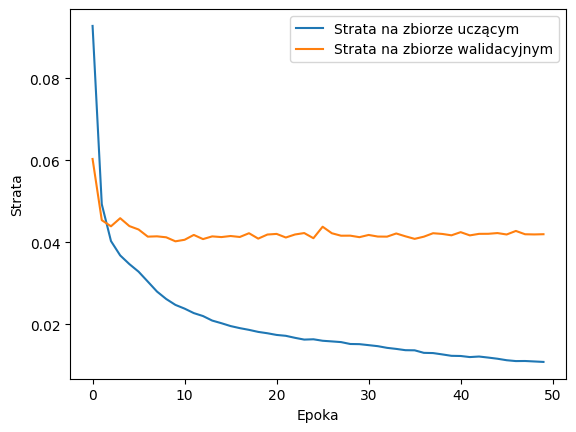

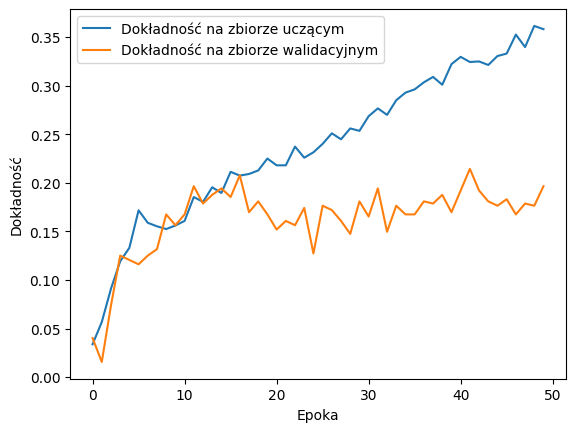

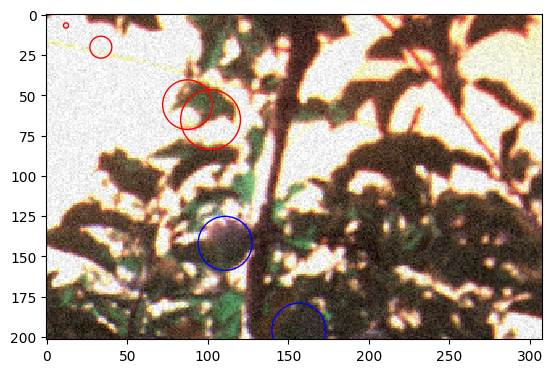

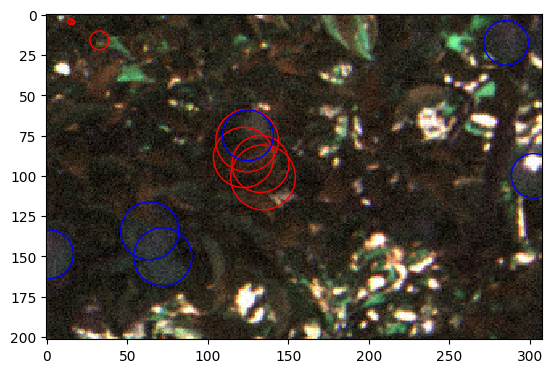

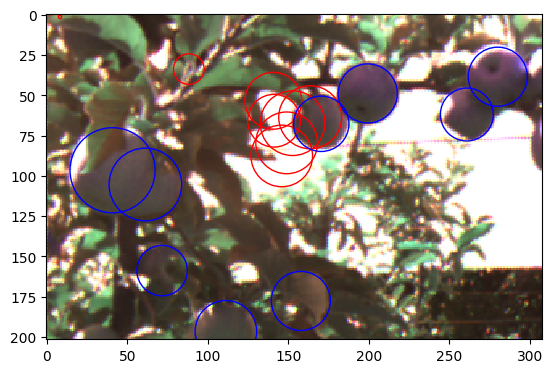

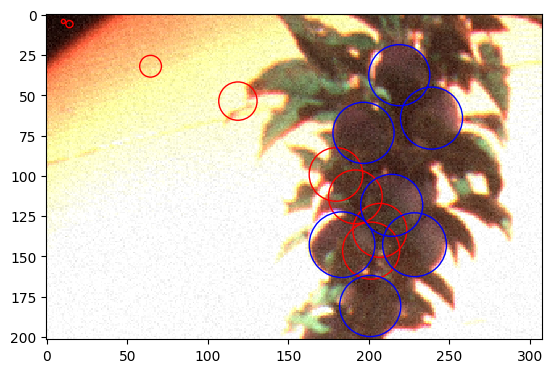

In [32]:
# Load model
model = load_model(
    r'<your model>',
    compile=False
)

# Plot training and validation loss
plt.plot(MODEL1_V1.history['loss'], label = 'Strata na zbiorze uczącym')
plt.plot(MODEL1_V1.history['val_loss'], label = 'Strata na zbiorze walidacyjnym')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(MODEL1_V1.history['accuracy'], label = 'Dokładność na zbiorze uczącym')
plt.plot(MODEL1_V1.history['val_accuracy'], label = 'Dokładność na zbiorze walidacyjnym')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

# Loop through 4 test images
l = [134,98,67,245]
for i in l:
    # Reshape the input test image
    input_image_reshaped = np.expand_dims(test_set_img[i], axis=0)
    
    # Make predictions using the model
    trainprediction = model.predict(input_image_reshaped)
    
    # Inverse transform the predictions using 'train_set_coords_transformer'
    trainprediction = train_set_coords_transformer.inverse_transform(trainprediction)
    
    # Apply a threshold and split the predictions
    prediction = apply_threshold_and_split_pred(trainprediction, 0)
    
    # Get the original coordinates from 'test_set_coords'
    original_coords = split_origin(test_set_coords[i])
    
    # Plot the results
    plot_results(test_set_img[i], prediction, original_coords)

In [34]:
# Print max and min values for metrics
print(max(MODEL1_V1.history['loss']))
print(max(MODEL1_V1.history['val_loss']))
print(max(MODEL1_V1.history['accuracy']))
print(max(MODEL1_V1.history['val_accuracy']))

print('--------------')

print(min(MODEL1_V1.history['loss']))
print(min(MODEL1_V1.history['val_loss']))
print(min(MODEL1_V1.history['accuracy']))
print(min(MODEL1_V1.history['val_accuracy']))

0.09276574105024338
0.0603364035487175
0.361328125
0.2142857164144516
--------------
0.010866031982004642
0.04026392102241516
0.0337611623108387
0.015625


In [12]:
model = load_model(
    r'<your model>',
    compile=False
)


dataset = []
prob = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

# Initialize an empty dataset
dataset = []

# Define probability values
prob = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

subset_img  = train_set_img
subset_coords = train_set_coords

# Iterate over each item 
for i in range(len(subset_coords)):
    # Reshape the input validation image
    input_image_reshaped = np.expand_dims(subset_img[i], axis=0)
    
    # Make predictions using the model
    trainprediction = model.predict(input_image_reshaped, verbose=0)
    
    # Inverse transform the predictions using 'train_set_coords_transformer'
    trainprediction = train_set_coords_transformer.inverse_transform(trainprediction)
    
    # Apply Non-Maximum Suppression (NMS)
    pred_after_nms = NMS(trainprediction[0], 0.7, 0, prob)
    
    # Extract predictions without the last element (assuming it's a class label)
    only_pred_after_nms = []
    for list_ in pred_after_nms:
        only_pred_after_nms.append(list_[:-1])
    
    # Get the original coordinates 
    original_coords = split_origin(subset_coords[i])
    
    # Filter out coordinates with a last element less than or equal to zero
    original_coords_without_zeros = []
    for elem in original_coords:
        if elem[-1] > 0:
            original_coords_without_zeros.append(elem)
    
    # Append the tuple of original coordinates and post-NMS predictions to the dataset
    dataset.append((original_coords_without_zeros, only_pred_after_nms))

# Calculate the mean average precision (mAP) for the dataset
mean_map = mean_average_precision(dataset, iou_thresholds=np.arange(0.5, 1.0, 0.05))

print(f"Średnia mAP: {mean_map*100} %")

Średnia mAP: 0.050216267062380505 %


DRUGI MODEL

In [13]:
# Loading file paths with raw data
path_img_test = r'datasets_splited\dataset\test_aug\images'
path_csv_test = r'datasets_splited\dataset\test_aug\annotations'

path_img_train = r'datasets_splited\dataset\train_aug\images'
path_csv_train = r'datasets_splited\dataset\train_aug\annotations'

path_img_val = r'datasets_splited\dataset\val_aug\images'
path_csv_val = r'datasets_splited\dataset\val_aug\annotations'

#Functions invocation
df_circle_test = create_df(path_csv_test)
list_of_coords_test = get_bbox_cords(df_circle_test)
images_test = get_image_data(path_img_test)
list_of_prob_test = calculate_prob(list_of_coords_test)

df_circle_train = create_df(path_csv_train)
list_of_coords_train = get_bbox_cords(df_circle_train)
images_train = get_image_data(path_img_train)
list_of_prob_train = calculate_prob(list_of_coords_train)

df_circle_val = create_df(path_csv_val)
list_of_coords_val = get_bbox_cords(df_circle_val)
images_val = get_image_data(path_img_val)
list_of_prob_val = calculate_prob(list_of_coords_val)

#Inserting data into numpy arrays and splitting to train and test set
test_set_coords = np.array(list_of_coords_test)
test_set_img = np.array(images_test).astype(np.uint16)
test_set_prob = list_of_prob_test

train_set_coords = np.array(list_of_coords_train)
train_set_img = np.array(images_train).astype(np.uint16)
train_set_prob = list_of_prob_train

valid_set_coords = np.array(list_of_coords_val)
valid_set_img = np.array(images_val).astype(np.uint16)
valid_set_prob = list_of_prob_val

print(len(test_set_coords))
print(len(test_set_img))
print(len(train_set_coords))
print(len(train_set_img))
print(len(valid_set_coords))
print(len(valid_set_img))
print(len(train_set_prob))
print(len(test_set_prob))
print(len(valid_set_prob))

# Normalizing bboxes data
train_set_coords_transformer = MaxAbsScaler().fit(train_set_coords)
train_set_coords_scaled = train_set_coords_transformer.transform(train_set_coords)

test_set_coords_transformer = MaxAbsScaler().fit(test_set_coords)
test_set_coords_scaled = test_set_coords_transformer.transform(test_set_coords)

valid_set_coords_transformer = MaxAbsScaler().fit(valid_set_coords)
valid_set_coords_scaled = valid_set_coords_transformer.transform(valid_set_coords)

448
448
3584
3584
448
448
3584
448
448


In [ ]:
# Define the input shape
input_shape = (202, 308, 3)

# Create the model
model = tf.keras.Sequential()

# Load VGG16 as the backbone (excluding the fully connected layers)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
model.add(vgg16)

# Add a Masking layer to handle sequences with variable lengths (number of apples)
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

# Output Layer for bounding box coordinates (c-x, c-y, radius)
bbox_output = Dense(54, activation='linear', name='bbox_output')(model.layers[-1].output)  # Linear activation for bbox

# Output Layer for probability scores
prob_output = Dense(18, activation='sigmoid', name='prob_output')(model.layers[-1].output)  # Sigmoid activation for prob

# Set VGG16 layer not trainable
model.layers[0].trainable=False

# Create a model with multiple outputs
model = tf.keras.Model(inputs=model.input, outputs=[bbox_output, prob_output])

# Compile the model with custom loss functions for each output
def bbox_loss(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

def prob_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)

# You can assign different loss weights if needed
loss_weights = {'bbox_output': 1.0, 'prob_output': 1.0}

custom_optimizer  = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss={'bbox_output': bbox_loss, 'prob_output': prob_loss}, optimizer=custom_optimizer, loss_weights=loss_weights)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss',patience=40),
    tf.keras.callbacks.ModelCheckpoint(filepath='calls2/model.{epoch:02d}-{loss:.4f}.h5')
]

#Train model
history_aug_v9 = model.fit(train_set_img,
    [train_set_coords_scaled, train_set_prob],
    batch_size=64,
    epochs=1000,
    verbose=2,
    shuffle = True,
    validation_data=(valid_set_img, [valid_set_coords_scaled, valid_set_prob]),
    callbacks=my_callbacks
)

#Model summary
model.summary()

#Save model
model.save('models/aug_v9_model.h5')

Epoch 1/1000
42/42 - 375s - loss: 4.7472 - bbox_output_loss: 3.7481 - prob_output_loss: 0.9991 - val_loss: 0.8378 - val_bbox_output_loss: 0.1544 - val_prob_output_loss: 0.6834 - 375s/epoch - 9s/step
Epoch 2/1000
42/42 - 404s - loss: 0.8855 - bbox_output_loss: 0.2032 - prob_output_loss: 0.6823 - val_loss: 0.8129 - val_bbox_output_loss: 0.1440 - val_prob_output_loss: 0.6690 - 404s/epoch - 10s/step
Epoch 3/1000
42/42 - 401s - loss: 0.7732 - bbox_output_loss: 0.1123 - prob_output_loss: 0.6608 - val_loss: 0.7439 - val_bbox_output_loss: 0.0901 - val_prob_output_loss: 0.6539 - 401s/epoch - 10s/step
Epoch 4/1000
42/42 - 384s - loss: 0.7575 - bbox_output_loss: 0.1086 - prob_output_loss: 0.6489 - val_loss: 0.7442 - val_bbox_output_loss: 0.1019 - val_prob_output_loss: 0.6424 - 384s/epoch - 9s/step
Epoch 5/1000
42/42 - 396s - loss: 0.7416 - bbox_output_loss: 0.1049 - prob_output_loss: 0.6368 - val_loss: 0.7040 - val_bbox_output_loss: 0.0758 - val_prob_output_loss: 0.6282 - 396s/epoch - 9s/step
Epo

In [17]:
# Load model
model = load_model(
    r'<your model>',
    compile=False
)

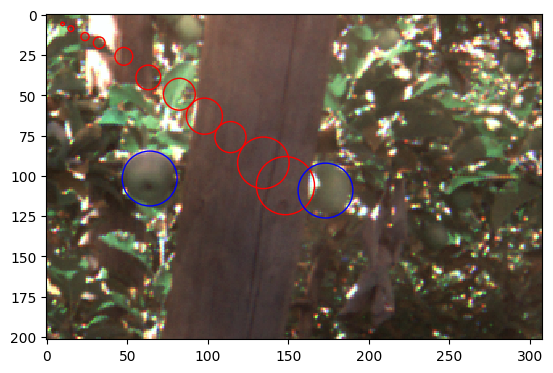

In [26]:
num = 100

input_image_reshaped = np.expand_dims(test_set_img[num], axis=0)
trainprediction, predictions=model.predict(input_image_reshaped)
trainprediction = train_set_coords_transformer.inverse_transform(trainprediction)
prediction = apply_threshold_and_split_pred(trainprediction, 1)
original_coords = split_origin(test_set_coords[num])
plot_results(test_set_img[num], prediction, original_coords)

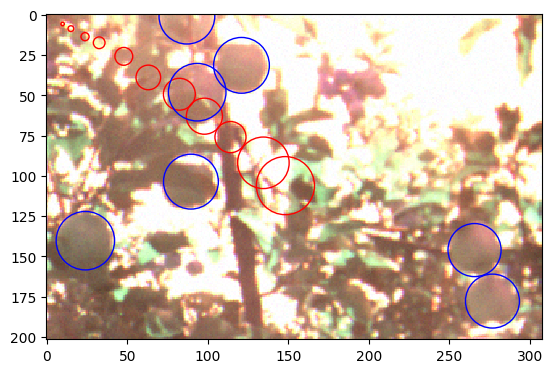

In [20]:
num = 240

input_image_reshaped = np.expand_dims(test_set_img[num], axis=0)
trainprediction, predictions=model.predict(input_image_reshaped)
trainprediction = train_set_coords_transformer.inverse_transform(trainprediction)
prediction = apply_threshold_and_split_pred(trainprediction, 1)
original_coords = split_origin(test_set_coords[num])
plot_results(test_set_img[num], prediction, original_coords)

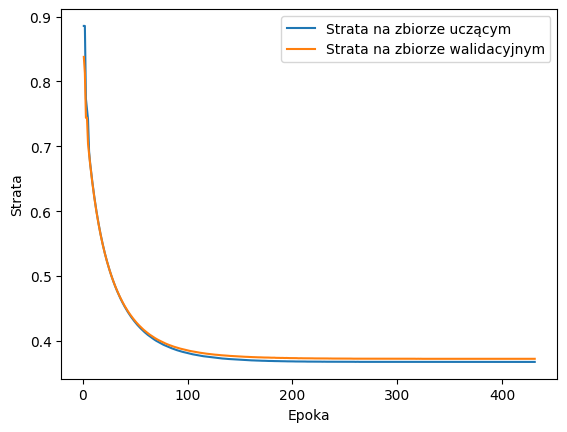

In [ ]:
# Plot training and validation loss
plt.plot(history_aug_v9.history['loss'], label = 'Strata na zbiorze uczącym')
plt.plot(history_aug_v9.history['val_loss'], label = 'Strata na zbiorze walidacyjnym')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [17]:
model = load_model(
    r'<your model>',
    compile=False
)

# Initialize an empty dataset
dataset = []

subset_img  = test_set_img
subset_coords = test_set_coords

for i in range(len(subset_coords)):
    input_image_reshaped = np.expand_dims(subset_img[i], axis=0)
    trainprediction, prob =model.predict(input_image_reshaped, verbose = 0)
    trainprediction = train_set_coords_transformer.inverse_transform(trainprediction)
    pred_after_nms = NMS(trainprediction[0],0.7,0,prob[0])
    only_pred_after_nms = []
    for list_ in pred_after_nms:
        only_pred_after_nms.append(list_[:-1])
    original_coords = split_origin(subset_coords[i])
    original_coords_without_zeros = []
    for elem in original_coords:
        if elem[-1] > 0:
            original_coords_without_zeros.append(elem)   
    dataset.append((original_coords_without_zeros,only_pred_after_nms))

mean_map = mean_average_precision(dataset, iou_thresholds=np.arange(0.5, 1.0, 0.05))
print(f"Średnia mAP: {mean_map*100} %")

Średnia mAP: 0.03992783010640153 %


TRZECI MODEL

In [5]:
# Loading file paths with raw data
path_img_test = r'datasets_splited\dataset\test_aug\images'
path_csv_test = r'datasets_splited\dataset\test_aug\annotations'

path_img_train = r'datasets_splited\dataset\train_aug\images'
path_csv_train = r'datasets_splited\dataset\train_aug\annotations'

path_img_val = r'datasets_splited\dataset\val_aug\images'
path_csv_val = r'datasets_splited\dataset\val_aug\annotations'

#Functions invocation
df_circle_test = create_df(path_csv_test)
list_of_coords_test = get_bbox_cords(df_circle_test)
images_test = get_image_data(path_img_test)
list_of_prob_test = calculate_prob(list_of_coords_test)

df_circle_train = create_df(path_csv_train)
list_of_coords_train = get_bbox_cords(df_circle_train)
images_train = get_image_data(path_img_train)
list_of_prob_train = calculate_prob(list_of_coords_train)

df_circle_val = create_df(path_csv_val)
list_of_coords_val = get_bbox_cords(df_circle_val)
images_val = get_image_data(path_img_val)
list_of_prob_val = calculate_prob(list_of_coords_val)

# Split data into cells
transformed_coords_test, transformed_probs_test = transform_data(list_of_coords_test, list_of_prob_test, (4,4))
transformed_coords_train, transformed_probs_train = transform_data(list_of_coords_train, list_of_prob_train, (4,4))
transformed_coords_val, transformed_probs_val = transform_data(list_of_coords_val, list_of_prob_val, (4,4))

#Inserting data into numpy arrays and splitting to train and test set
test_set_coords = np.array(transformed_coords_test)
test_set_img = np.array(images_test)
test_set_prob = transformed_probs_test

train_set_coords = np.array(transformed_coords_train)
train_set_img = np.array(images_train)
train_set_prob = transformed_probs_train

valid_set_coords = np.array(transformed_coords_val)
valid_set_img = np.array(images_val)
valid_set_prob = transformed_probs_val

print(len(test_set_coords))
print(len(test_set_img))
print(len(train_set_coords))
print(len(train_set_img))
print(len(valid_set_coords))
print(len(valid_set_img))
print(len(train_set_prob))
print(len(test_set_prob))
print(len(valid_set_prob))

# Reshape the data into 2D
train_set_coords_2D = train_set_coords.reshape(-1, train_set_coords.shape[-1])

# Scale the 2D data
train_set_coords_transformer = MaxAbsScaler().fit(train_set_coords_2D)
train_set_coords_scaled_2D = train_set_coords_transformer.transform(train_set_coords_2D)

# Reshape the scaled data back into 5D
train_set_coords_scaled = train_set_coords_scaled_2D.reshape(train_set_coords.shape)

# Repeat for the test and validation sets
test_set_coords_2D = test_set_coords.reshape(-1, test_set_coords.shape[-1])
test_set_coords_transformer = MaxAbsScaler().fit(test_set_coords_2D)
test_set_coords_scaled_2D = test_set_coords_transformer.transform(test_set_coords_2D)
test_set_coords_scaled = test_set_coords_scaled_2D.reshape(test_set_coords.shape)
valid_set_coords_2D = valid_set_coords.reshape(-1, valid_set_coords.shape[-1])
valid_set_coords_transformer = MaxAbsScaler().fit(valid_set_coords_2D)
valid_set_coords_scaled_2D = valid_set_coords_transformer.transform(valid_set_coords_2D)
valid_set_coords_scaled = valid_set_coords_scaled_2D.reshape(valid_set_coords.shape)

train_labels = np.concatenate([train_set_coords_scaled, train_set_prob], axis=-1)
valid_labels = np.concatenate([valid_set_coords_scaled, valid_set_prob], axis=-1)

448
448
3584
3584
448
448
3584
448
448


In [ ]:
# Constants

# Define grid size
grid_size = 4
# Define how many bboxes can be in one cell
bbox_per_cell = 2
num_classes = 1  # This is technically not used as I have a single class (circle)
# DEfine input shape
input_shape = (202, 308, 3)

# Create model
model = Sequential()

# Load VGG16 as backbone (without fully connected layers)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
model.add(vgg16)
model.add(UpSampling2D(size=(4,4)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization()) 
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(9,9)))
model.add(Reshape((-1, 4, 2, 4)))   

# Adding output layer
yolo_output_channels = bbox_per_cell * bbox_per_cell   # 4 coordinates 
model.add(Dense(yolo_output_channels, activation='linear'))

# Set VGG16 layer as non-trainable
model.layers[0].trainable = False

# YOLO Loss function
def yolo_loss(y_true, y_pred):

    true_coords = y_true[..., 0:3]
    true_prob = y_true[..., 3:4]

    pred_coords = y_pred[..., 0:3]
    pred_prob = y_pred[..., 3:4]
   # Compute the coordinate loss
    coords_loss = tf.reduce_sum(tf.square(true_coords - pred_coords))
    obj_loss = tf.reduce_sum(tf.expand_dims(tf.keras.losses.binary_crossentropy(true_prob, pred_prob), -1))

    loss = coords_loss + obj_loss
    return loss

# Compile model
custom_optimizer = Adam(learning_rate=0.0001)
model.compile(loss=yolo_loss, optimizer=custom_optimizer, metrics=['accuracy'])

# Define lr scheduler that makes lr smaller when there is no progress
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=2, 
                              verbose=1, 
                              min_delta=1e-4, 
                              min_lr=1e-10)

# Callbacks
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20),
    tf.keras.callbacks.ModelCheckpoint(filepath='calls3/model.{epoch:02d}-{loss:.4f}.h5'),
    #reduce_lr,
]

model.summary()

# Training
history_y1 = model.fit(
    train_set_img,  
    train_labels,   
    batch_size=64,
    epochs=50,
    verbose=2,
    shuffle=True,
    validation_data=(valid_set_img, valid_labels),  
    callbacks=my_callbacks
)

# Saving model
model.save('FINAL_MODELS/MODEL3_V0.h5')

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 9, 512)         14714688  
                                                                 
 up_sampling2d (UpSampling2D  (None, 24, 36, 512)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 24, 36, 32)        147488    
                                                                 
 batch_normalization (BatchN  (None, 24, 36, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 2

In [ ]:
# Load model
model = load_model(
    r'<your model>',
    compile=False
)

1/1 [==============================] - 0s 234ms/step


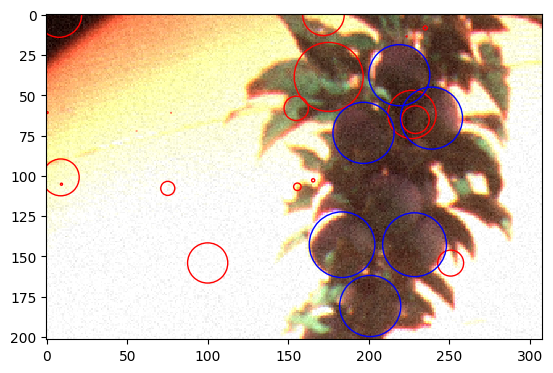

In [ ]:
# Define the index of the test image to process
num = 245

# Reshape the input test image
input_image_reshaped = np.expand_dims(test_set_img[num], axis=0)

# Make predictions using the model
predictions = model.predict(input_image_reshaped)

# Reverse transform and normalize the predictions
dt = reverse_transform_data(predictions, (4, 4))

# Initialize an array with zeros
arr = np.zeros((1, 4, 4, 2, 3))

# Copy values from 'predictions' to 'arr' element by element
for i in range(4):
    for j in range(4):
        for k in range(2):
            for x in range(3):
                arr[0][i][j][k][x] = predictions[0][i][j][k][x]

# Reshape 'arr' to a 2D array
arr_2D = arr.reshape(-1, train_set_coords.shape[-1])

# Inverse transform the 2D array using 'train_set_coords_transformer'
trainprediction = train_set_coords_transformer.inverse_transform(arr_2D)

# Reshape 'trainprediction' to match its original shape
trainprediction = trainprediction.reshape(arr.shape)

# Reverse transform deep nested coordinates in 'trainprediction'
b = reverse_transform_deep_nested_coords(trainprediction, (4, 4))

# Reverse transform deep nested coordinates in 'test_set_coords' for comparison
test_set_coords_tr = reverse_transform_deep_nested_coords([test_set_coords[num]], (4, 4))

# Apply a threshold and split the predictions
prediction = apply_threshold_and_split_pred([b], 0)

# Get the original coordinates from 'test_set_coords_tr'
original_coords = split_origin(test_set_coords_tr)

# Plot the results
plot_results(test_set_img[num], prediction, original_coords)


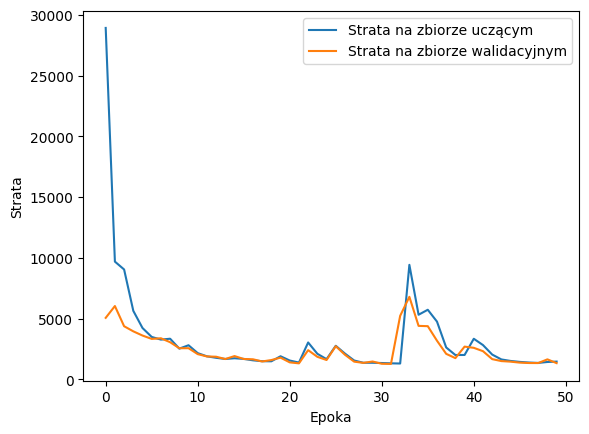

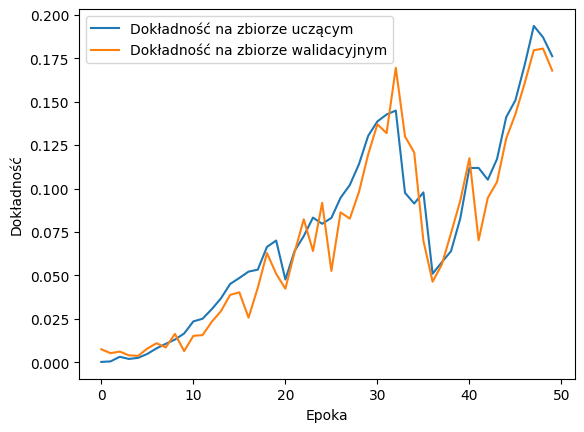

In [ ]:
# Plot training and validation loss
plt.plot(history_y1.history['loss'], label = 'Strata na zbiorze uczącym')
plt.plot(history_y1.history['val_loss'], label = 'Strata na zbiorze walidacyjnym')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history_y1.history['accuracy'], label = 'Dokładność na zbiorze uczącym')
plt.plot(history_y1.history['val_accuracy'], label = 'Dokładność na zbiorze walidacyjnym')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

In [ ]:
# Print max and min values for metrics
print(max(history_y1.history['loss']))
print(max(history_y1.history['val_loss']))
print(max(history_y1.history['accuracy']))
print(max(history_y1.history['val_accuracy']))

print('--------------')

print(min(history_y1.history['loss']))
print(min(history_y1.history['val_loss']))
print(min(history_y1.history['accuracy']))
print(min(history_y1.history['val_accuracy']))

28928.447265625
6799.40576171875
0.1936209499835968
0.1805943101644516
--------------
1312.384765625
1278.099853515625
0.00019182477262802422
0.0036969867069274187


In [8]:
# Load model
model = load_model(
    r'<your model>',
    compile=False
)

dataset = []

subset_img  = train_set_img
subset_coords = train_set_coords

# Initialize an empty dataset
dataset = []

# Iterate over each item in 'subset_coords'
for i in range(len(subset_coords)):
    # Reshape the input image
    input_image_reshaped = np.expand_dims(subset_img[i], axis=0)
    
    # Make predictions using the model
    predictions = model.predict(input_image_reshaped, verbose=0)

    # Reverse transform and normalize the predictions
    dt, probab = reverse_transform_data(predictions, (4, 4))

    # Initialize an array with zeros
    arr = np.zeros((1, 4, 4, 2, 3))
    
    # Copy values from 'predictions' to 'arr' element by element
    for i in range(4):
        for j in range(4):
            for k in range(2):
                for x in range(3):
                    arr[0][i][j][k][x] = predictions[0][i][j][k][x]

    # Reshape 'arr' to a 2D array
    arr_2D = arr.reshape(-1, train_set_coords.shape[-1])
    
    # Inverse transform the 2D array using 'train_set_coords_transformer'
    trainprediction = train_set_coords_transformer.inverse_transform(arr_2D)
    
    # Reshape 'trainprediction' to match its original shape
    trainprediction = trainprediction.reshape(arr.shape)
    
    # Reverse transform deep nested coordinates in 'trainprediction'
    b = reverse_transform_deep_nested_coords(trainprediction, (4, 4))
    
    # Reverse transform deep nested coordinates in 'subset_coords' for comparison
    test_set_coords_tr = reverse_transform_deep_nested_coords([subset_coords[i]], (4, 4))
    
    # Apply Non-Maximum Suppression (NMS)
    pred_after_nms = NMS(b, 0.7, 0.3, probab[0])
    
    # Extract predictions without the last element
    only_pred_after_nms = []
    for list_ in pred_after_nms:
        only_pred_after_nms.append(list_[:-1])
    
    # Get the original coordinates from 'test_set_coords_tr'
    original_coords = split_origin(test_set_coords_tr)
    
    # Filter out coordinates with a last element less than or equal to zero
    original_coords_without_zeros = []
    for elem in original_coords:
        if elem[-1] > 0:
            original_coords_without_zeros.append(elem)
    
    # Append the tuple of original coordinates and post-NMS predictions to the dataset
    dataset.append((original_coords_without_zeros, only_pred_after_nms))

# Calculate the mean average precision (mAP) for the dataset
mean_map = mean_average_precision(dataset, iou_thresholds=np.arange(0.1, 1.0, 0.05))

print(f"Średnia mAP: {mean_map*100} %")

Średnia mAP: 0.0 %
